# Data Preparation for Defensive Player

In this notebook we will prepare the data for the Most Valuable Player award prediction.

#### Load Dependencies

In [25]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('..')

from data_scripts import _store_data as sd
from pathlib import Path

sd.load_data(Path("../data"))

#### Copy and Prepare Player Data

This section prepares player defensive statistics for analysis:

- **Copy Dataset:** Create a copy of the original player-team dataset to preserve the source data.  
- **Convert Key Stats to Float:** Ensure important defensive statistics are numeric for accurate calculations.  
- **Aggregate by Player and Year:** Group the data by player and year, summing stats to get yearly totals per player.
- **Add Season 11 Data:** Include additional data from Season 11 for completeness.
- **Sort Data:** Organize the aggregated data by player and year to facilitate multi-year defensive score computations.

In [26]:
mvp_info_df = sd.players_teams_df.copy()

cols_to_agg = ['points', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'fgMade', 'fgAttempted', 'GP']

for col in cols_to_agg:
    mvp_info_df[col] = mvp_info_df[col].astype(float)

mvp_info_df = mvp_info_df.groupby(['playerID', 'year'], as_index=False)[cols_to_agg].sum()

# Adding data from Season 11
players_teams_year11_df = pd.read_csv("../basketballPlayoffs/Season_11/players_teams.csv")

mvp_info_df = pd.concat([mvp_info_df, players_teams_year11_df], ignore_index=True)

mvp_info_df = mvp_info_df.sort_values(['playerID', 'year'])

#### Compute Score Function

This section defines a function to calculate a defensive score for each player per season:

- **Normalize by Games Played:** Adjust statistics to account for differences in games played.  
- **Add Performance Features:** Calculate current and historical weighted performance scores.  
- **Compute Overall Score:** Combine the weighted stats into a single defensive score for each player per season.

In [27]:
def overall_performance(PTS, REB, AST, STL, BLK, TOV, FGM, FGA, GP):
    if GP == 0 or FGA == 0:
        return 0 
    FG_percent = FGM / FGA
    return (
        (PTS / GP) +
        (REB / GP) * 1.2 +
        (AST / GP) * 1.5 +
        (STL / GP) * 3 +
        (BLK / GP) * 2 -
        (TOV / GP) * 2 +
        FG_percent * 10
    )


#### Calculate Multi-Year Scores

This section computes multi-year scores for each player:

- **Previous Seasons:** Calculate defensive scores for the past 1, 2, and 3 years.  
- **Use `compute_defense_score` Function:** Apply the function to generate per-season scores.  
- **Create Lagged Features:** Generate lagged statistics to capture trends over multiple seasons, useful for predictive modeling.


In [28]:
for shift_years in [1, 2, 3]:
    col_suffix = f"prev_{shift_years}yr"

    
    shifted_points = mvp_info_df.groupby('playerID')['points'].shift(shift_years)
    shifted_assists = mvp_info_df.groupby('playerID')['assists'].shift(shift_years)
    shifted_turnovers = mvp_info_df.groupby('playerID')['turnovers'].shift(shift_years)
    shifted_fgMade = mvp_info_df.groupby('playerID')['fgMade'].shift(shift_years)
    shifted_fgAttempted = mvp_info_df.groupby('playerID')['fgAttempted'].shift(shift_years)
    shifted_gp = mvp_info_df.groupby('playerID')['GP'].shift(shift_years)
    shifted_rebounds = mvp_info_df.groupby('playerID')['rebounds'].shift(shift_years)
    shifted_steals = mvp_info_df.groupby('playerID')['steals'].shift(shift_years)
    shifted_pf = mvp_info_df.groupby('playerID')['blocks'].shift(shift_years)

    
    overall_performance_scores = pd.Series(
        [overall_performance(
            shifted_points.iloc[i], shifted_rebounds.iloc[i], shifted_assists.iloc[i],
            shifted_steals.iloc[i], shifted_pf.iloc[i], shifted_turnovers.iloc[i],
            shifted_fgMade.iloc[i], shifted_fgAttempted.iloc[i], shifted_gp.iloc[i])
         for i in range(len(mvp_info_df))],
        index=mvp_info_df.index
    )
    
    mvp_info_df[f'overall_score_{col_suffix}'] = overall_performance_scores.fillna(0)

#### Drop Unnecessary Columns

This step cleans the dataset by removing irrelevant or redundant columns:

- **Remove Raw Stats:** Discard individual or intermediate statistics that are no longer needed.  
- **Keep Key Features:** Retain aggregated defensive scores and essential identifiers (e.g., player, year) for modeling.  
- **Simplify Dataset:** Streamline the data to focus only on the features relevant for predictive analysis.


In [29]:
columns_to_drop = [
    'GP', 'GS', 'minutes', 'points', 'oRebounds', 'dRebounds',
    'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF',
    'fgMade', 'fgAttempted', 'threeMade', 'threeAttempted',
    'ftMade', 'ftAttempted', 'PostthreeMade', 'PostthreeAttempted',
    'dq', 'PostGP', 'PostGS', 'PostMinutes', 'PostPoints', 'PostoRebounds',
    'PostdRebounds', 'PostRebounds', 'PostAssists', 'PostSteals', 'PostBlocks',
    'PostTurnovers', 'PostPF', 'PostfgMade', 'PostfgAttempted', 'PostthreeMade',
    'PostthreeAttempted', 'PostftMade', 'PostftAttempted', 'PostDQ',
    'height', 'weight', 'pos', 'birthDate', 'deathDate'
]
mvp_info_df.drop(columns=[col for col in columns_to_drop if col in mvp_info_df.columns], inplace=True)


#### Merge Defensive Player Award Information

This step incorporates the target variable for modeling performance:

- **Add Award Indicator:** Create a column showing whether the player won Most Valuable Player (1) or not (0) for each season.  
- **Merge with Player Data:** Combine award information with the prepared player dataset.  
- **Prepare for Modeling:** Ensure the dataset includes both features and the target variable for predictive analysis.


In [30]:
mvp_aw = sd.awards_players_df[sd.awards_players_df['award'].str.strip().str.lower() == 'most valuable player'].copy()
mvp_aw['mvp'] = 1

mvp_info_df = mvp_info_df.merge(
    mvp_aw[['playerID', 'year', 'mvp']],
    on=['playerID', 'year'],
    how='left'
)
mvp_info_df['mvp'] = mvp_info_df['mvp'].fillna(0).astype(int)

#### Reorder Columns and Save CSV

This step finalizes the dataset for modeling:

- **Reorder Columns:** Arrange columns logically for clarity and ease of use.  
- **Save to CSV:** Export the processed dataset to a CSV file for use in predictive modeling.  
- **Ready for Analysis:** Ensure the dataset is clean, organized, and contains all necessary features and target variables.

In [31]:
column_order = ['playerID', 'year', 'overall_score_prev_1yr', 'overall_score_prev_2yr', 'overall_score_prev_3yr', 'mvp']
mvp_info_df = mvp_info_df[column_order]

mvp_info_df.to_csv("../predict_datasets/mvp.csv", index=False)


#### Idea For the Dataset Preparation

Since this dataset is for most valuable player dataset, we calculated the overall performance score with the statistics of the player for each player. There could be some more statistics from the player that can be used if given but these are already good statistics to predict the best player.

#### Data Correlation Analysis

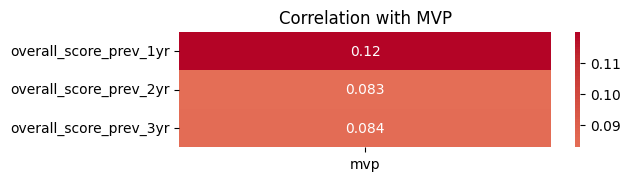

In [32]:
score_cols = ['overall_score_prev_1yr', 'overall_score_prev_2yr', 'overall_score_prev_3yr', 'mvp']
df_scores = mvp_info_df[score_cols]

corr_matrix = df_scores.corr()[['mvp']]

corr_matrix = corr_matrix.drop('mvp')

plt.figure(figsize=(6, len(corr_matrix)/2))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation with MVP")
plt.show()